In [62]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Loading data as a dataframe.

In [63]:
san_francisco = pd.read_csv("./datasets/Flood_Health_Vulnerability.csv")
san_francisco.head()

,Census Blockgroup,Children,Elderly,NonWhite,Poverty,Education,English,Elevation,SeaLevelRise,Precipitation,Diabetes,MentalHealth,Asthma,Disability,HousingViolations,Homeless,LivAlone,FloodHealthIndex,FloodHealthIndex_Quintiles
0,60759809001,0.072957,8.037850e-10,0.599175,0.356678,0.996080,0.150559,-6.00000,0.182261,0.035771,22.0584,36.5200,15.1339,0.133608,14.10930,17.5025,0.480591,84.8190,5
1,60750201001,0.079893,1.240000e-01,0.651000,0.509706,0.724000,0.232000,7.83292,0.000000,0.020516,16.0115,62.0535,10.5741,0.238000,10.24060,15.8921,0.522000,83.4860,5
2,60750117001,0.027149,1.030000e-01,0.697000,0.378595,0.862000,0.171000,-1.99906,0.106609,0.005321,1.4068,98.5924,0.8008,0.187000,39.56220,4.9374,0.635000,83.4791,5
3,60750178021,0.084215,8.800000e-02,0.584000,0.327362,0.843000,0.119000,-5.96629,0.064579,0.024166,14.9856,54.0699,9.5802,0.229000,7.04366,19.2683,0.427000,82.4925,5
4,60750125012,0.095332,2.219991e-01,0.726001,0.794750,0.694997,0.202999,7.13278,0.000000,0.004105,15.5000,63.7499,12.9672,0.424998,13.72550,14.6184,0.731997,81.8061,5


Basic Statistics

In [64]:
san_francisco.describe().drop("count", axis=0)

,Census Blockgroup,Children,Elderly,NonWhite,Poverty,Education,English,Elevation,SeaLevelRise,Precipitation,Diabetes,MentalHealth,Asthma,Disability,HousingViolations,Homeless,LivAlone,FloodHealthIndex,FloodHealthIndex_Quintiles
mean,6.075033e+10,0.131671,1.430411e-01,0.567669,0.271585,0.869517,0.124782,124.147322,0.010224,0.007366,8.317175,19.953382,4.748124,1.034424e-01,6.021817,4.713140,0.347597,49.569516,3.000000
std,8.011773e+05,0.057074,6.102362e-02,0.213813,0.154539,0.108676,0.108760,104.939767,0.050148,0.014039,6.101610,15.429652,3.384794,5.513568e-02,8.160820,5.726493,0.148501,13.343632,1.416662
min,6.075010e+10,0.007243,8.037850e-10,0.128998,0.057373,0.363000,0.000000,-42.000000,0.000000,0.000000,0.000000,0.051100,0.000000,1.050660e-09,0.000000,0.260200,0.062731,19.293200,1.000000
25%,6.075017e+10,0.089490,1.020000e-01,0.403000,0.165123,0.814500,0.046000,35.303625,0.000000,0.000816,4.300800,9.040000,2.710900,7.424997e-02,2.830483,0.520700,0.227000,39.561450,2.000000
50%,6.075025e+10,0.133925,1.390000e-01,0.565000,0.234190,0.899000,0.104500,111.691500,0.000000,0.002560,6.428200,14.280000,3.823850,9.378748e-02,4.763075,3.131250,0.325000,47.929400,3.000000
75%,6.075033e+10,0.170120,1.730000e-01,0.721750,0.331840,0.954001,0.180500,183.484250,0.000000,0.007140,11.200000,26.817075,5.460375,1.150000e-01,7.256355,4.615400,0.458551,58.226175,4.000000
max,6.075981e+10,0.452256,5.540000e-01,0.981456,0.840098,1.000999,0.715007,558.279000,0.503456,0.155139,97.368700,98.592400,16.115600,4.520000e-01,170.940000,19.268300,0.732000,84.819000,5.000000


Exploration with Flood Index Quintiles as a category

In [65]:
san_francisco.groupby("FloodHealthIndex_Quintiles").min()

,Census Blockgroup,Children,Elderly,NonWhite,Poverty,Education,English,Elevation,SeaLevelRise,Precipitation,Diabetes,MentalHealth,Asthma,Disability,HousingViolations,Homeless,LivAlone,FloodHealthIndex
FloodHealthIndex_Quintiles,,,,,,,,,,,,,,,,,,
1,60750128002,0.044489,2.977580e-02,0.186000,0.057373,0.775194,0.000000,-6.75712,0.0,0.0,0.0,0.0511,0.0,2.400003e-02,0.193517,0.2606,0.139000,19.2932
2,60750126022,0.044489,4.999985e-02,0.128998,0.057373,0.705228,0.000000,-7.20480,0.0,0.0,0.0,5.1498,0.0,2.400000e-02,0.000000,0.2606,0.064521,37.8997
3,60750102002,0.028313,5.000000e-02,0.155000,0.071228,0.686715,0.006000,-1.31835,0.0,0.0,0.0,5.1600,0.0,3.700004e-02,0.340483,0.2606,0.065000,44.2862
4,60750102001,0.007243,2.330006e-02,0.155000,0.069069,0.496997,0.009882,-16.99000,0.0,0.0,0.0,0.9466,0.0,1.050660e-09,0.000000,0.2606,0.062731,51.2730
5,60750101001,0.009804,8.037850e-10,0.408160,0.129087,0.363000,0.034926,-42.00000,0.0,0.0,0.0,4.0262,0.0,4.685419e-02,0.237586,0.2602,0.087000,61.2794


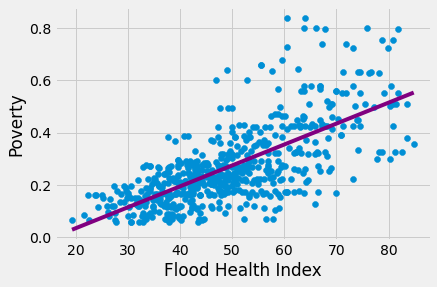

In [66]:
x = san_francisco["FloodHealthIndex"]
y = san_francisco["Poverty"]
x.corr(y)
a, b = np.polyfit(x, y, 1)
matplotlib.pyplot.scatter(x, y)
matplotlib.pyplot.plot(x, a*x+b, color='purple') 
plt.xlabel("Flood Health Index")
plt.ylabel("Poverty")
matplotlib.pyplot.show()